In [1]:
import nmresearch as nmr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

import pickle

In [2]:
# decent color schemes for plots and such

colors = [
    "#1984c5",
    "#22a7f0",
    "#63bff0",
    "#a7d5ed",
    "#e2e2e2",
    "#e1a692",
    "#de6e56",
    "#e14b31",
    "#c23728",
]

colors_single = [
    "#fff5eb",
    "#fee6ce",
    "#fdd0a2",
    "#fdae6b",
    "#fd8d3c",
    "#f16913",
    "#d94801",
    "#a63603",
    "#7f2704",
]
colors_single.reverse()
zcorr_str = r"$\langle$ $\hat{S}_z (nT)$ $\hat{S}_z$ $\rangle$"
xcorr_str = r"$\langle$ $\hat{S}_x (nT)$ $\hat{S}_x$ $\rangle$"
mucorr_str = r"$\langle$ $\hat{S}_\mu (nT)$ $\hat{S}_\mu$ $\rangle$"
zcorr_loc_str = r"$\langle$ $\hat{S}_z^{(0)} (nT)$ $\hat{S}_z^{(0)}$ $\rangle$"

In [3]:
plt.rcParams.update({"font.size": 14})
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"

In [4]:
def get_tpc_data(filename, expt_no, folder="expt9", normalize=True):
    filename = "data/" + filename
    try:
        data = pickle.load(open(filename, "rb"))
    except FileNotFoundError:
        data = nmr.Experiment(expt_no, folder=folder).load_tpc(
            use_real=False, normalize=normalize
        )
        with open(filename, "wb") as f:
            pickle.dump(data, f)
    return data


def get_tpc3d_data(filename, expt_no, folder="expt9", normalize=False):
    filename = "data/" + filename
    try:
        data = pickle.load(open(filename, "rb"))
    except FileNotFoundError:
        data = nmr.Experiment(expt_no, folder=folder).load_tpc3d(
            use_real=False, normalize=normalize
        )
        with open(filename, "wb") as f:
            pickle.dump(data, f)
    return data

In [5]:
24 * 4 * 2

192

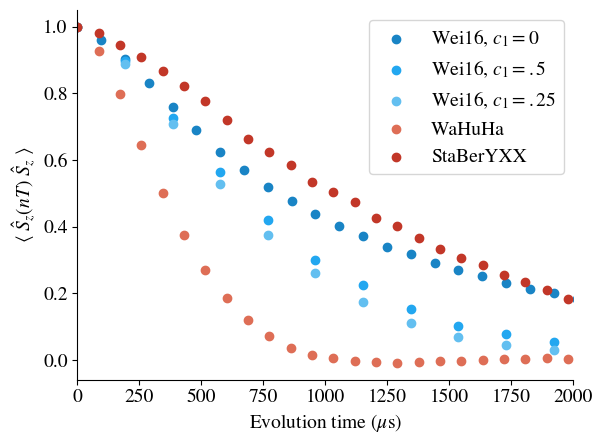

In [6]:
# Test the performance of the disorder generators vai their suspension performance
# e.g. seq_susp = seq + pi + seq + pi, except wei16, which can be tuned to suspension
# with the c1 knob

staber_pi = get_tpc_data("staber_pi.dat", 344)
whh_pi = get_tpc_data("whh_pi.dat", 282)
staberYXX_zz = get_tpc_data("staberYXX_zz.dat", 380)
staberYXX_xx = get_tpc_data("staberYXX_xx.dat", 382)
ken_suspension = get_tpc_data("ken_suspension.dat", 279)
ken_50_pi = get_tpc_data("ken_50_pi.dat", 582)
ken_25_pi = get_tpc_data("ken_25_pi.dat", 583)
t_list = np.arange(0, 25, 1) * 96


plt.scatter(t_list, ken_suspension, label=r"Wei16, $c_1=0$", color=colors[0])
plt.scatter(t_list * 2, ken_50_pi, label=r"Wei16, $c_1=.5$", color=colors[1])
plt.scatter(t_list * 2, ken_25_pi, label=r"Wei16, $c_1=.25$", color=colors[2])
plt.scatter(t_list * (43 * 2 / 96), whh_pi, label="WaHuHa", color=colors[6])
plt.scatter(
    t_list * (43 * 2 / 96), staberYXX_zz[:25], label="StaBerYXX", color=colors[-1]
)

plt.legend()
plt.xlabel(r"Evolution time ($\mu$s)")
plt.xlim([0, 2000])
plt.ylabel(zcorr_str)
# plt.title("Suspension Performance of Disorder Generators")
plt.savefig("supension_performance.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("suspension_performance.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

In [7]:
def find_one_over_e_time(data, times):
    one_over_e_times = {}
    for label, series in data.items():
        initial_value = series[0]
        one_over_e_value = initial_value / np.e
        one_over_e_time = None
        for t, value in zip(times, series):
            if value <= one_over_e_value:
                one_over_e_time = t
                break
        one_over_e_times[label] = one_over_e_time
    return one_over_e_times


# Find 1/e times for the plotted curves
one_over_e_times_ken_suspension = find_one_over_e_time(
    {"ken_suspension": ken_suspension}, t_list
)
one_over_e_times_ken_50_pi = find_one_over_e_time({"ken_50_pi": ken_50_pi}, t_list * 2)
one_over_e_times_whh_pi = find_one_over_e_time(
    {"whh_pi": whh_pi}, t_list * (43 * 2 / 96)
)
one_over_e_times_staberYXX_zz = find_one_over_e_time(
    {"staberYXX_zz": staberYXX_zz[:25]}, t_list * (43 * 2 / 96)
)

# Combine all results
one_over_e_times = {
    **one_over_e_times_ken_suspension,
    **one_over_e_times_ken_50_pi,
    **one_over_e_times_whh_pi,
    **one_over_e_times_staberYXX_zz,
}

print("1/e times for each curve:")
for label, time in one_over_e_times.items():
    print(f"{label}: {time} µs")

1/e times for each curve:
ken_suspension: 1248 µs
ken_50_pi: 960 µs
whh_pi: 516.0 µs
staberYXX_zz: 1376.0 µs


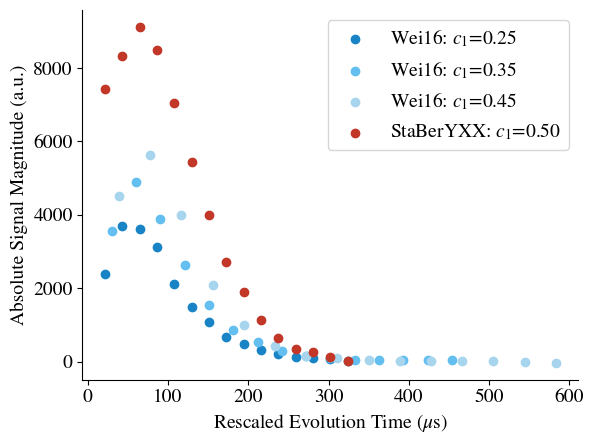

In [8]:
# Test the measurable signal for the disordered state preparation technique
wei16_25 = get_tpc_data("wei16_25.dat", 317, normalize=False)
wei16_35 = get_tpc_data("wei16_35.dat", 318, normalize=False)
wei16_45 = get_tpc_data("wei16_45.dat", 319, normalize=False)
# staber_100 = get_tpc_data("staber_100.dat", 346, normalize=False)
staberYXX_50 = get_tpc_data("staberYXX_50.dat", 353, normalize=False)

tau = 3.6
T = 24 * tau
times = np.arange(1, 16, 1) * T
plt.scatter(0.25 * times, wei16_25, label=r"Wei16: $c_1$=0.25", color=colors[0])
plt.scatter(0.35 * times, wei16_35, label=r"Wei16: $c_1$=0.35", color=colors[2])
plt.scatter(0.45 * times, wei16_45, label=r"Wei16: $c_1$=0.45", color=colors[3])
# plt.scatter(times / 2, staber_100, label=r"Staber: $c_1$=1.00", color=colors[5])
plt.scatter(
    0.5 * times / 2, staberYXX_50, label=r"StaBerYXX: $c_1$=0.50", color=colors[8]
)
plt.legend()
plt.xlabel(r"Rescaled Evolution Time ($\mu$s)")
plt.ylabel("Absolute Signal Magnitude (a.u.)")
plt.savefig("disorder_prep.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("disorder_prep.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

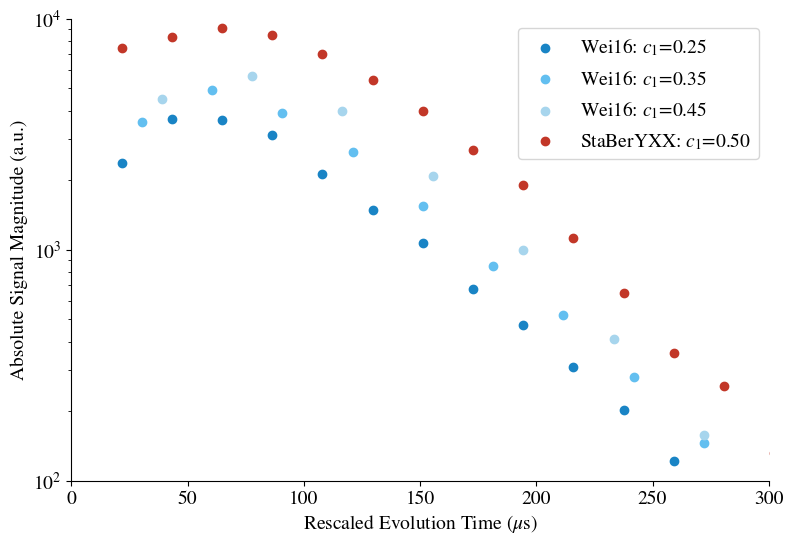

In [9]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.set_yscale("log")
ax.scatter(0.25 * times, wei16_25, label=r"Wei16: $c_1$=0.25", color=colors[0])
ax.scatter(0.35 * times, wei16_35, label=r"Wei16: $c_1$=0.35", color=colors[2])
ax.scatter(0.45 * times, wei16_45, label=r"Wei16: $c_1$=0.45", color=colors[3])
# ax.scatter(times / 2, staber_100, label=r"Staber: $c_1$=1.00", color=colors[5])
ax.scatter(
    0.5 * times / 2, staberYXX_50, label=r"StaBerYXX: $c_1$=0.50", color=colors[8]
)
ax.legend()
plt.xlim(0, 300)
plt.ylim(1e2, 1e4)
plt.xlabel(r"Rescaled Evolution Time ($\mu$s)")
plt.ylabel("Absolute Signal Magnitude (a.u.)")
plt.savefig("disorder_prep_log.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("disorder_prep_log.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

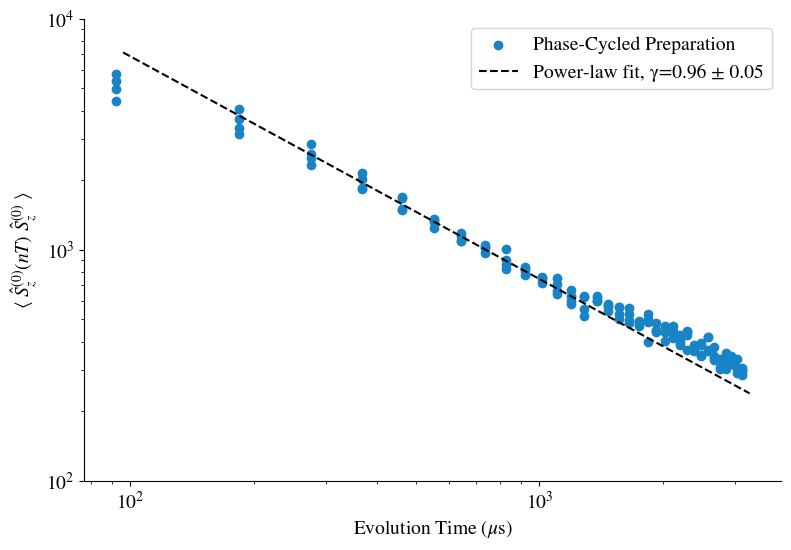

In [10]:
diffusion_data = get_tpc3d_data("diffusion_data.dat", 572)
t_list = lambda start, end: [92 * t for t in range(start, end) for _ in range(4)]

tau = 4
T = 24 * tau
times = np.arange(0, 35, 1) * T

start = 5
end = 15
x = np.log(t_list(start, end))
X = sm.add_constant(x)
y = -np.log(diffusion_data[start:end].flatten())
ols = sm.OLS(y, X)
ols_result = ols.fit()
slopes = ols_result.params[1]
err = ols_result.conf_int()[1, 1] - ols_result.params[1]


fig, ax = plt.subplots(figsize=(9, 6))
ax.set_xscale("log")
ax.set_yscale("log")
ax.scatter(
    t_list(0, 35),
    diffusion_data.flatten(),
    color=colors[0],
    label="Phase-Cycled Preparation",
)
ax.plot(
    times[1:],
    np.exp(-ols_result.params[0]) * times[1:] ** (-ols_result.params[1]),
    label=f"Power-law fit, γ={ols_result.params[1]:.2f} ± {err:.2f}",
    color="black",
    linestyle="--",
)
plt.xlabel(r"Evolution Time ($\mu$s)")
plt.ylabel(zcorr_loc_str)
plt.ylim(1e2, 1e4)
plt.legend()
plt.savefig("diffusion_demo.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("diffusion_demo.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

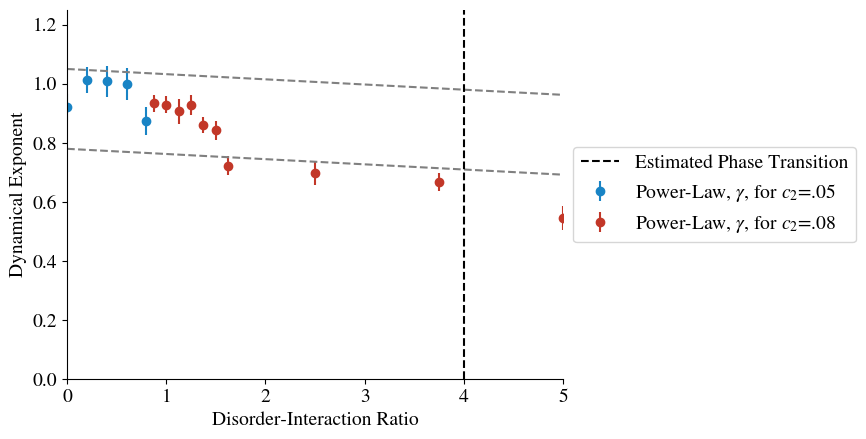

In [16]:
data05 = {}
data05[np.sqrt(0) / 0.05] = get_tpc_data("c1_00_c2_05.dat", 424, normalize=False)
data05[np.sqrt(0.01**2) / 0.05] = get_tpc_data("c1_01_c2_05.dat", 427, normalize=False)
data05[np.sqrt(0.02**2) / 0.05] = get_tpc_data("c1_02_c2_05.dat", 428, normalize=False)
data05[np.sqrt(0.03**2) / 0.05] = get_tpc_data("c1_03_c2_05.dat", 435, normalize=False)
data05[np.sqrt(0.04**2) / 0.05] = get_tpc_data("c1_04_c2_05.dat", 436, normalize=False)


expt_3d_c208 = get_tpc3d_data("c1_3d_c2_08.dat", 486)
expt_3d_c208pt2 = get_tpc3d_data("c1_3d_c2_08pt2.dat", 496)

data08 = {}
c1_vals = [0.9, 0.10, 0.11, 0.12, 0.13, 0.2, 0.3, 0.4]
c2 = 0.08
for c1, series in zip(c1_vals, expt_3d_c208):
    data08[c1 / c2] = series
c1_vals = [0.07, 0.08, 0.09, 0.10, 0.11]
for c1, series in zip(c1_vals, expt_3d_c208pt2):
    data08[c1 / c2] = series


def slope_extraction(
    time, data, start, end, color, ylabel="Slope", xlabel="dependent var", labelstr=""
):
    slopes = []
    dependent = []
    errs = []
    for key, val in data.items():
        x = np.log(time[start:end])
        X = sm.add_constant(x)
        y = -np.log(val[start:end])
        ols = sm.OLS(y, X)
        ols_result = ols.fit()
        dependent.append(key)
        slopes.append(ols_result.params[1])
        errs.append(ols_result.conf_int()[1, 1] - ols_result.params[1])

    # plt.scatter(dependent, slopes,label='Fit w/ 95% C.I. ' + labelstr)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.errorbar(
        dependent,
        slopes,
        yerr=errs,
        linestyle="",
        marker="o",
        label=r"Power-Law, $\gamma$, for " + labelstr,
        color=color,
    )


start = 1
end = 20
slope_extraction(
    times,
    data05,
    start,
    end,
    xlabel="Disorder-Interaction Ratio",
    ylabel="Dynamical Exponent",
    labelstr=r"$c_2$=.05",
    color=colors[0],
)
slope_extraction(
    times,
    data08,
    start,
    end,
    ylabel="Dynamical Exponent",
    labelstr=r"$c_2$=.08",
    xlabel="Disorder-Interaction Ratio",
    color=colors[-1],
)
dis_range = np.arange(0, 5, 0.01)
plt.plot(dis_range, -0.0175 * dis_range + 1.05, linestyle="--", color="grey")
plt.plot(dis_range, -0.0175 * dis_range + 0.78, linestyle="--", color="grey")
plt.ylim([0, 1.25])
plt.xlim([0, 5])
plt.vlines(4, 0, 1.5, linestyle="--", color="black", label="Estimated Phase Transition")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig("disorder_transition_early.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("disorder_transition_early.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

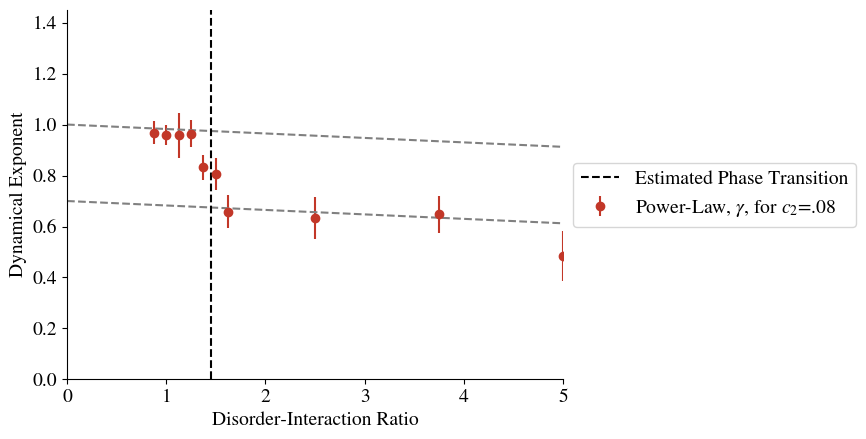

In [26]:
start = 5
end = 20
"""
slope_extraction(
times,
data05,
start,
end,
xlabel="Disorder-Interaction Ratio",
ylabel="Dynamical Exponent",
labelstr=r"$c_2$=.05",
color=colors[0],
)
"""

slope_extraction(
    times,
    data08,
    start,
    end,
    ylabel="Dynamical Exponent",
    labelstr=r"$c_2$=.08",
    xlabel="Disorder-Interaction Ratio",
    color=colors[-1],
)
dis_range = np.arange(0, 16, 0.01)
plt.plot(dis_range, -0.0175 * dis_range + 1, linestyle="--", color="grey")
plt.plot(dis_range, -0.0175 * dis_range + 0.7, linestyle="--", color="grey")
plt.ylim([0, 1.45])
plt.xlim([0, 5])
plt.vlines(
    1.45, 0, 1.5, linestyle="--", color="black", label="Estimated Phase Transition"
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig("disorder_transition_mid.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("disorder_transition_mid.png", format="png", dpi=900, bbox_inches="tight")
plt.show()

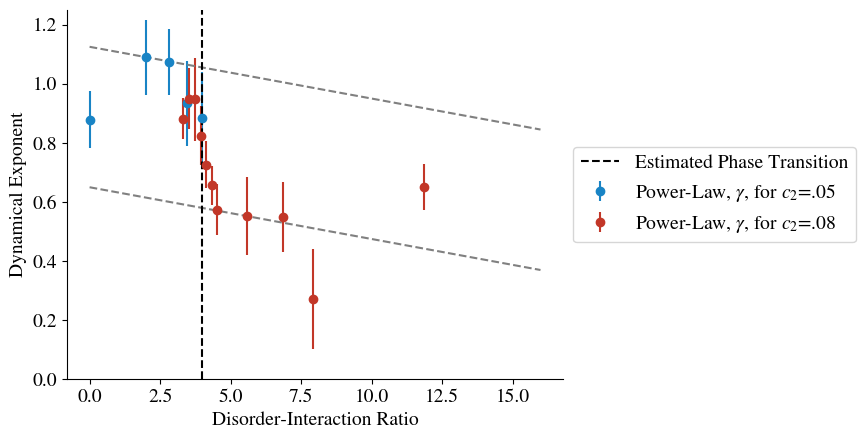

In [15]:
start = 10
end = 25
slope_extraction(
    times,
    data05,
    start,
    end,
    xlabel="Disorder-Interaction Ratio",
    ylabel="Dynamical Exponent",
    labelstr=r"$c_2$=.05",
    color=colors[0],
)
slope_extraction(
    times,
    data08,
    start,
    end,
    ylabel="Dynamical Exponent",
    labelstr=r"$c_2$=.08",
    xlabel="Disorder-Interaction Ratio",
    color=colors[-1],
)
dis_range = np.arange(0, 16, 0.01)
plt.plot(dis_range, -0.0175 * dis_range + 1.125, linestyle="--", color="grey")
plt.plot(dis_range, -0.0175 * dis_range + 0.65, linestyle="--", color="grey")
plt.ylim([0, 1.25])
plt.vlines(4, 0, 1.5, linestyle="--", color="black", label="Estimated Phase Transition")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.savefig("disorder_transition_late.pdf", format="pdf", dpi=900, bbox_inches="tight")
plt.savefig("disorder_transition_late.png", format="png", dpi=900, bbox_inches="tight")
plt.show()